In [1]:
import sys
import json
import torch
import pickle 
import numpy as np
import matplotlib as mpl
sys.path.insert(0, "../../src")
from matplotlib import pyplot as plt
from models import TransformerEncoder
from torch.utils.data import DataLoader
from matplotlib.ticker import MultipleLocator 
from datasets import MVTSDataset, find_padding_masks
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
# Read in validation indices
with open('../../data/data_indices.json', 'r') as f: data_indices = json.load(f)
val_indices = data_indices['val_indices']

# Create loader
val_dataloader = DataLoader(MVTSDataset(val_indices, norm_type='unity', mean_mask_length=3,
                                        masking_ratio=0.15), batch_size=len(val_indices), shuffle=False, drop_last=False)

In [6]:
# Load best trained model

model = TransformerEncoder(feat_dim=35,
                           max_len=40,
                           d_model=64,
                           n_heads=8,
                           num_layers=1,
                           dim_feedforward=256,
                           freeze=True)
model.float()
model.load_state_dict(torch.load('../../temp/inputting_unity_norm.pt'))
model.eval();

In [7]:
# Creat data and masks

x, mask, _ = next(iter(val_dataloader))
padding_mask = find_padding_masks(x) 
x = torch.nan_to_num(x)
x_masked = x * mask 
target_masks = ~mask  
x = x.to(device)
x_masked = x_masked.to(device)
target_masks = target_masks.to(device)
padding_mask = padding_mask.to(device)
y_hat, _ = model(x_masked, padding_mask)
x_masked[x_masked == 0]  = np.nan

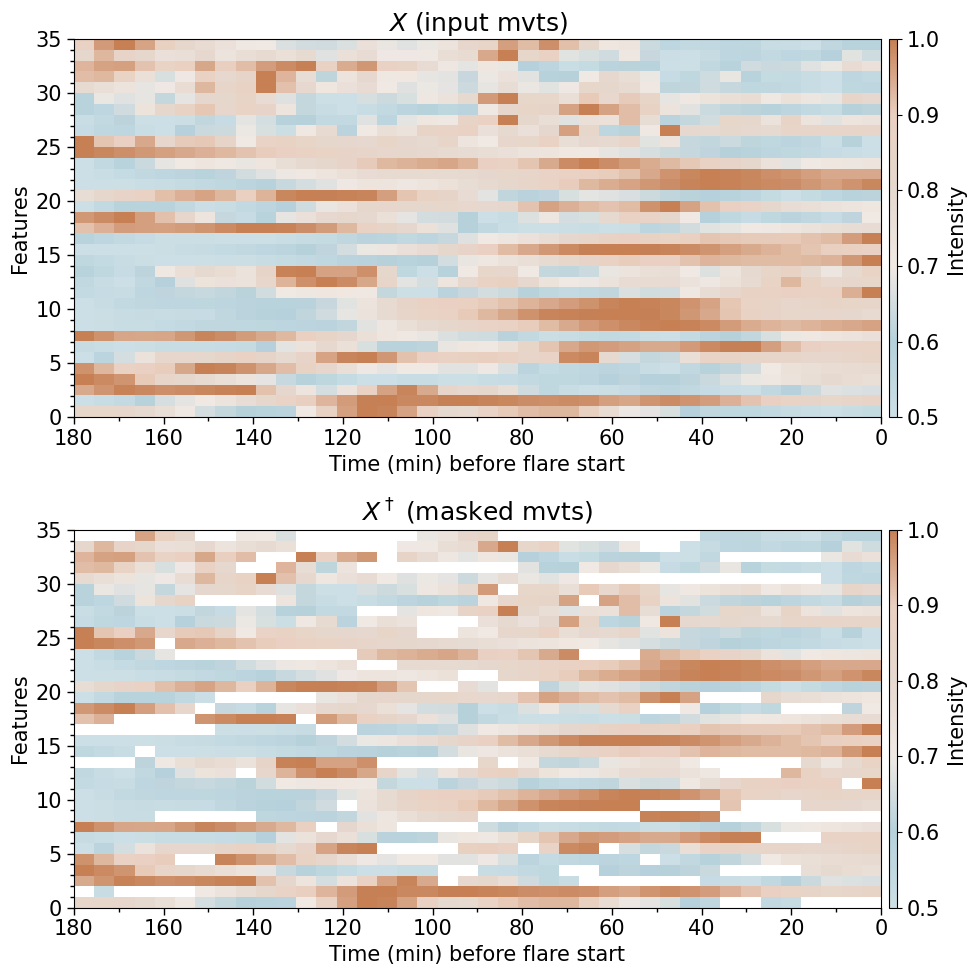

In [7]:
# Plot input and masked input

indx = 64
# Create a figure and subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))
mpl.rcParams['font.size'] = 15
# Load custom color map
with open('/Users/brandonlpanos/custom_cmap.pkl', 'rb') as f: custom_cmap = pickle.load(f)

im1 = ax1.imshow(x[indx].T, aspect='auto', cmap=custom_cmap, interpolation='none', label='target', extent=[180, 0, 0, 35], alpha=0.8)
ax1.set_title(r'$X$' + ' (input mvts)')
ax1.set_ylabel('Features')
ax1.set_xlabel('Time (min) before flare start')
cbar1 = plt.colorbar(im1, cax=ax1.inset_axes([1.01, 0, 0.01, 1]), aspect=10)
ax1.xaxis.set_major_locator(MultipleLocator(20))
ax1.xaxis.set_minor_locator(MultipleLocator(10))
ax1.yaxis.set_major_locator(MultipleLocator(5))
ax1.yaxis.set_minor_locator(MultipleLocator(1))
ax1.tick_params(which='major', length=5,width=1)
ax1.tick_params(which='minor', length=3,width=1)
cbar1.set_label('Intensity')

# Plot the second subplot
im2 = ax2.imshow(x_masked[indx].T, aspect='auto', cmap=custom_cmap, interpolation='none', label='target', extent=[180, 0, 0, 35], alpha=0.8)
ax2.set_title(r'$X^\dagger$' + ' (masked mvts)')
ax2.set_ylabel('Features')
ax2.set_xlabel('Time (min) before flare start')
cbar2 = plt.colorbar(im2, cax=ax2.inset_axes([1.01, 0, 0.01, 1]), aspect=10)
ax2.xaxis.set_major_locator(MultipleLocator(20))
ax2.xaxis.set_minor_locator(MultipleLocator(10))
ax2.yaxis.set_major_locator(MultipleLocator(5))
ax2.yaxis.set_minor_locator(MultipleLocator(1))
ax2.tick_params(which='major', length=5,width=1)
ax2.tick_params(which='minor', length=3,width=1)
cbar2.set_label('Intensity')
plt.tight_layout()

# plt.savefig(f'/Users/brandonlpanos/papers/transformer/figs/plot_x_x_masked.png', dpi=300, bbox_inches='tight')

plt.show()
plt.close()